In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import colors
from astropy.timeseries import LombScargle
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import find_peaks

In [3]:
nudot_data = np.loadtxt("B1826-17_mjd_nudot_err.dat")
mjd = nudot_data[:,0]          # MJD values
nudot = nudot_data[:,1]        # Nudot values (in 1e-15)
nudot_err = nudot_data[:,2]    # Uncertainty values (in 1e-15)

plt.figure(figsize=(20,5))

plt.errorbar(mjd,y=nudot,yerr=nudot_err,fmt='k.-',ecolor='r',label='nudot')
plt.xlabel('MJD')
plt.ylabel(r'$\dot{\nu}$ [$10^{-15}$Hz]')
#plt.ylim(-367.5,-358)

FileNotFoundError: B1826-17_mjd_nudot_err.dat not found.

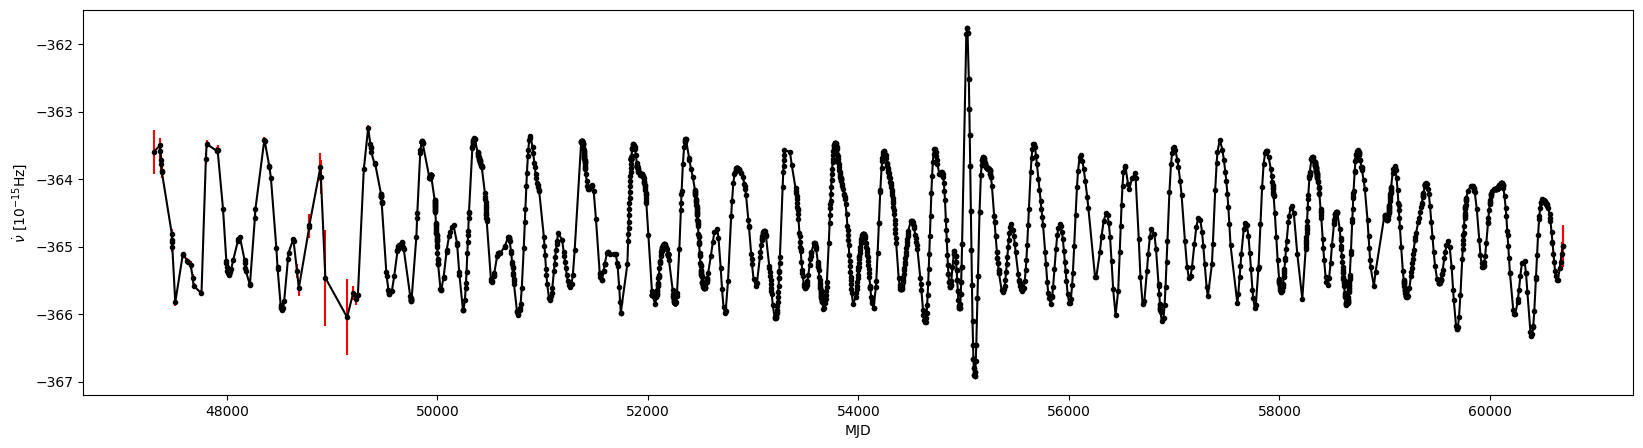

In [4]:
crop = 12
plt.figure(figsize=(20,5))
plt.errorbar(mjd[crop:],y=nudot[crop:],yerr=nudot_err[crop:],fmt='k.-',ecolor='r',label='nudot')
plt.xlabel('MJD')
plt.ylabel(r'$\dot{\nu}$ [$10^{-15}$Hz]')

mjd = nudot_data[crop:,0]          # MJD values
nudot = nudot_data[crop:,1]        # Nudot values (in 1e-15)
nudot_err = nudot_data[crop:,2]    # Uncertainty values (in 1e-15)

In [5]:
print(len(mjd))
print(mjd[0])
print(mjd[-400])

1989
47304.282896473
58378.854868473005


In [6]:
def striding_lombscargle(mjd, nudot, nudot_err, window_size=2100, step_size=1):
    times = [(date - mjd[0]) / 365.25 for date in mjd]

    periods = np.arange(699,91,-1)
    freqs = 365.25/periods

    # Container for results
    window_centers = []
    window_length = []
    power_spectra = []

    # Perform striding
    start = mjd[0]
    end = mjd[-1]
    total_steps = int((end - start - window_size) / step_size)
    
    with tqdm(total=total_steps) as pbar:
        while start + window_size < end:
            window_t = np.array([])
            window_d = np.array([])
            window_y = np.array([])
            window_yerr = np.array([])

            for i,day in enumerate(mjd):
                if day >= start and day <= start + window_size:
                    window_t = np.append(window_t, times[i])
                    window_d = np.append(window_d, day)
                    window_y = np.append(window_y, nudot[i])
                    window_yerr = np.append(window_yerr, nudot_err[i])
                else:
                    #print(day)
                    pass

            window_length.append(window_d[-1] - window_d[0])

            # Compute Lomb-Scargle periodogram
            pgram = LombScargle(window_t, window_y, window_yerr).power(
                frequency=freqs,
                method='auto',
                normalization='psd'
            )


            plt.plot(365.25/freqs, pgram, 'k',alpha=0.005)
            plt.xlim(0,700)
            plt.xlabel('Switch Period [days]')
            plt.ylabel('Power')

            power_spectra.append(pgram)

            # Record the center of the window
            window_centers.append(np.mean(window_d))

            # Slide the window
            start += step_size
            pbar.update(1)

    print(f'{np.mean(window_length)} +- {np.std(window_length)}')
    print(min(window_length))
    print(max(window_length))
    print(min(window_centers))
    print(max(window_centers))

    plt.show()

    return np.array(window_centers), power_spectra

In [7]:
def period_peaks(power_spectra):
    fund_period = []
    first_harmonic = []
    periods = np.arange(699,91,-1)
    for pgram in power_spectra:
        peaks, _ = find_peaks(pgram, height=0)
        sorted_indices = np.argsort(pgram[peaks])[::-1]

        fund_period.append(periods[peaks[sorted_indices[0]]])
        first_harmonic.append(periods[peaks[sorted_indices[1]]])
    return fund_period, first_harmonic

In [8]:
def line_fitting(x_data, y_data):
    weights = np.ones_like(y_data)  # Uniform weight for each point
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)
    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    y_fit = slope * x_data + offset
    residuals = y_data - y_fit
    sigma_squared = np.sum(residuals**2) / (len(x_data) - 2)  # Degrees of freedom (n - 2)
    slope_uncertainty = np.sqrt(sigma_squared / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term * sigma_squared)
    return (np.array([slope, slope_uncertainty]), np.array([offset, offset_uncertainty]))

In [15]:
def plot_power_spectra(window_centers, power_spectra, fund_period, first_harmonic, title='Striding Lomb-Scargle Periodogram', cmap='binary', plot_line=False, full=False):
    periods = np.arange(699,91,-1)
    freqs = 365.25/periods

    obs_start = np.floor(window_centers[0])
    obs_end = np.ceil(window_centers[-1])

    days = np.arange(obs_start, obs_end + 1, 1)

    n_data_points = np.shape(power_spectra)[1]

    power_spectra_daily_grid = np.empty((len(days), n_data_points))
    fund_period_daily = np.empty((len(days)))
    first_harmonic_daily = np.empty((len(days)))

    for i, day in enumerate(days):
        nearest_indices = np.abs(window_centers - day).argmin()
        power_spectra_daily_grid[i, :] = power_spectra[nearest_indices] 
        fund_period_daily[i] = fund_period[nearest_indices]
        first_harmonic_daily[i] = first_harmonic[nearest_indices]

    plt.imshow(np.flip(power_spectra_daily_grid,axis=1), aspect='auto', origin='lower', interpolation='none', cmap=cmap, extent=[min(365.25/freqs), max(365.25/freqs), days[0], days[-1]])

    if plot_line:
        plt.plot(fund_period_daily,days,'tab:blue',label='Fundamental')
        plt.plot(first_harmonic_daily,days, 'tab:orange',label='First Harmonic')
        gradient, intercept = line_fitting(window_centers,fund_period)
        gradient2, intercept2 = line_fitting(window_centers,first_harmonic)
        plt.plot(gradient[0]*window_centers+intercept[0],window_centers,'b',linestyle='--')
        plt.plot(gradient2[0]*window_centers+intercept2[0],window_centers,'r',linestyle='--')
        print(f'Fundamental Gradient: {gradient[0]} +- {gradient[1]}')
        print(f'First Harmonic Gradient: {gradient2[0]} +- {gradient2[1]}')

    if full:
        plt.axhline(y=50675.27343133259, color='red', linestyle='--')
        plt.axhline(y=53985.46452018442, color='red', linestyle='--')

    plt.xlim(0,700)
    plt.xlabel('Switch Period [days]')
    plt.ylabel('MJD of Mid-Point')
    plt.title(title)

    plt.show()

    return

49741.555626473004
54979.970666473004


  8%|▊         | 254/3138 [00:02<00:29, 97.45it/s]


KeyboardInterrupt: 

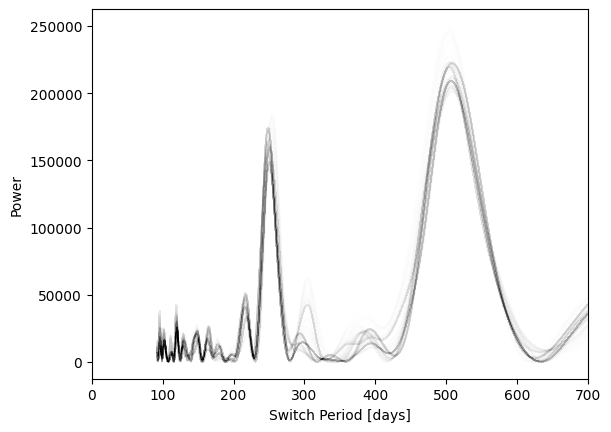

In [11]:
ash_mjd = np.array([])
ash_nudot = np.array([])
ash_nudot_err = np.array([])


for i,day in enumerate(mjd):
    if day >= 49710 and day <= 54980:
        ash_mjd = np.append(ash_mjd, day)
        ash_nudot = np.append(ash_nudot, nudot[i])
        ash_nudot_err = np.append(ash_nudot_err, nudot_err[i])
    else:
        #print(day)
        pass

print(ash_mjd[0])
print(ash_mjd[-1])

ash_centres,ash_power_spectra=striding_lombscargle(ash_mjd, ash_nudot, ash_nudot_err)
full_centres,full_power_spectra=striding_lombscargle(mjd, nudot, nudot_err)

In [ ]:
#np.save('ash_periodogram',ash_power_spectra)
#np.save('ash_centres',ash_centres)
#np.save('full_periodogram',full_power_spectra)
#np.save('full_centres',full_centres)

In [12]:
ash_power_spectra = np.load('ash_periodogram.npy')
ash_centres = np.load('ash_centres.npy')
full_power_spectra = np.load('full_periodogram.npy')
full_centres = np.load('full_centres.npy')

Fundamental Gradient: -0.01615727366390435 +- 2.533258521882724e-06
First Harmonic Gradient: -0.006665117000785116 +- 4.33320314720898e-06


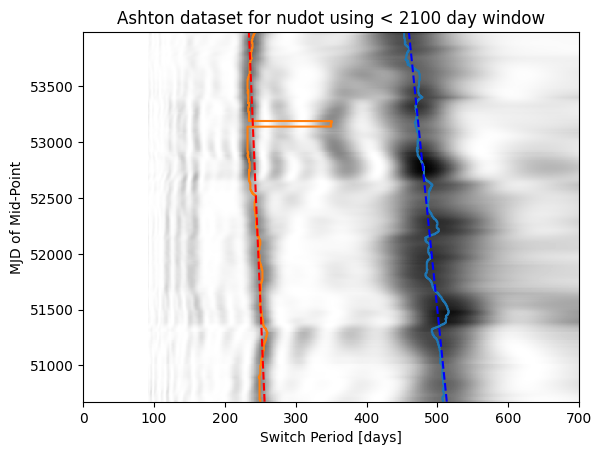

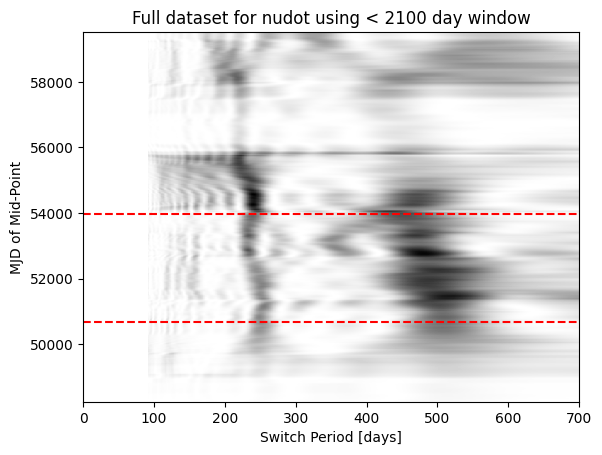

In [16]:
ash_fund_period, ash_first_harmonic = period_peaks(ash_power_spectra)
plot_power_spectra(ash_centres,ash_power_spectra,ash_fund_period,ash_first_harmonic,title='Ashton dataset for nudot using < 2100 day window', plot_line=True)
full_fund_period, full_first_harmonic = period_peaks(full_power_spectra)
plot_power_spectra(full_centres,full_power_spectra,full_fund_period,full_first_harmonic,title='Full dataset for nudot using < 2100 day window', full=True)

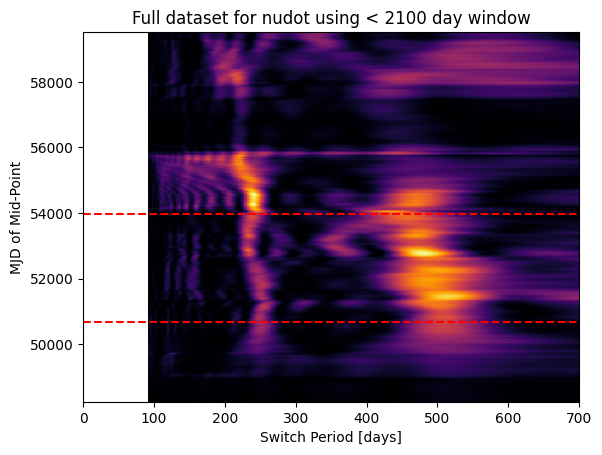

In [17]:
plot_power_spectra(full_centres, full_power_spectra, full_fund_period, full_first_harmonic, title='Full dataset for nudot using < 2100 day window', cmap='inferno', plot_line=False, full=True)

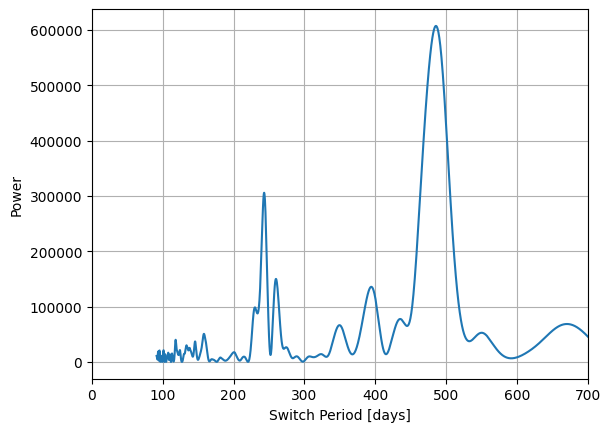

In [24]:
times = [(date - ash_mjd[0]) / 365.25 for date in ash_mjd]
 
times = np.asarray(times)

freqs, pgram = LombScargle(times,ash_nudot,ash_nudot_err).autopower(
        minimum_frequency=0.01,
        maximum_frequency=4,
        samples_per_peak=1000,
        normalization='psd'
    )

plt.plot(365.25/freqs,pgram)
plt.xlim(0,700)
plt.xlabel('Switch Period [days]')
plt.ylabel('Power')
plt.grid()